## Problem description
Given a set of cities $\{c_1, c_2, ..., c_N\}$, find the path $P\in\mathbb{N}^N$ (where each $P_i$ is the index of a city) that passes through all the cities with the least total travelling distance.


## Constrained quadratic formulation
The Travellig Salesman problem can be modeled as the following constrained quadratic optimization model:

$$x^* = \min_{x \in \mathbb{B}^{N\times N}} \left\{
    \sum_{p=2}^N \sum_{i=1}^N \sum_{j \neq i }^N d_{(i,j)} x_{(i,p)} x_{(j,p-1)} 
    + \sum_{i=1}^N \sum_{j \neq i }^N d_{(i,j)} x_{(i,0)} x_{(j,N)} \right\}, 
\quad \forall_{1 \leq i \leq N}: \sum_{p=1}^N x^*_{(i,p)} = 1, 
\quad \forall_{1 \leq p \leq N}: \sum_{i=1}^N x^*_{(i,p)} = 1$$

where:
* $x_{(i,p)} \in \mathbb{B}$ - indicates that the i-th city of the map is allocated in the p-th position of the path;
* $d_{(i,j)} \in \mathbb{R}$ - distance between i-th and j-th cities.

Once $x^*$ is found, the path $P=[P_1, P_2, ..., P_N]$ is defined as $P_p = \max_{0 \leq i \leq N} x_{(i,p)}$.


## Converting to QUBO

To convert the 1th equation to a QUBO model, we can transform the constraits into quadratic penalty terms $H_1(x), H_2(x)$:

$$H_1(x) = \sum_{i=1}^N \left( \sum_{p=1}^N x_{(i,p)} - 1 \right)^2 = \sum_{i=1}^N \left( \sum_{p=1}^N \sum_{q=1}^N x_{(i,p)} x_{(i,q)} - 2 \sum_{p=1}^N x_{(i,p)} + 1\right) = \sum_{i=1}^N \sum_{p=1}^N \sum_{q=1}^N x_{(i,p)}  x_{(i,q)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)} + N$$

$$H_2(x) = \sum_{p=1}^N \left( \sum_{i=1}^N x_{(i,p)} - 1 \right)^2 = \sum_{p=1}^N \left( \sum_{i=1}^N \sum_{j=1}^N x_{(i,p)} x_{(j,p)} - 2 \sum_{i=1}^N x_{(i,p)} + 1\right) = \sum_{p=1}^N \sum_{i=1}^N \sum_{j=1}^N x_{(i,p)}  x_{(j,p)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)} + N$$

Since the constant $N$ does not change the final result of the optimization, we can simply cut it out of the term.

$$H_1(x) = \sum_{i=1}^N \sum_{p=1}^N \sum_{q=1}^N x_{(i,p)}  x_{(i,q)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)}$$

$$H_2(x) = \sum_{p=1}^N \sum_{i=1}^N \sum_{j=1}^N x_{(i,p)}  x_{(j,p)} - 2 \sum_{i=1}^N \sum_{p=1}^N x_{(i,p)}$$

The final objective function is:

$$L(x) = \sum_{p=2}^N \sum_{i=1}^N \sum_{j \neq i}^N d_{(i,j)} x_{(i,p)} x_{(j,p-1)} + \gamma (H_1(x) + H_2(x))$$

where $\gamma \in \mathbb{R}$ is a penalty factor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from getpass import getpass
import dimod
from dwave.system import LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler

In [2]:
N = 10 # Number of cities

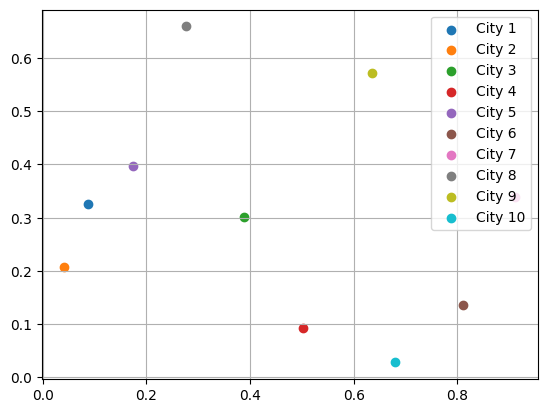

In [3]:
c = np.random.rand(N, 2) # Generate random coordinates to each city

# --- Plot cities ---
for i in range(N):
    plt.scatter(c[i,0], c[i,1], label=f'City {i+1}')

plt.legend()
plt.grid()
plt.show()

In [4]:
# -- Distances ---
d = np.zeros(shape=(N,N))
for i in range(N):
    for j in range(N):
        d[i,j] = np.linalg.norm(c[i,:] - c[j,:]) # Euclidean distance between c_i and c_j

In [5]:
# --- Generate variables ---
x_indexes = np.zeros(shape=(N,N), dtype=int)

count = 0
for i in range(N):
    for p in range(N):
        x_indexes[i,p] = count
        count += 1

#The following function maps indexes of the 2D array of variables to indexes of the 1D array that is sent to DWave's cloud
x = lambda city, position: int(x_indexes[city, position]) 

In [6]:
# --- Generate the QUBO matrix ---
gamma = 10.0 # Penalty factor

qubo = {(a,b):0 for a in range(N**2) for b in range(N**2) if b >= a} # QUBO matrix as a dict

st = lambda a, b: (a, b) if a <= b else (b, a) # returns a sorted 2-uple

# main term
for p in range(1, N):
    for i in range(N):
        for j in range(N):
            if i != j:
                qubo[st(x(i,p), x(j,p-1))] += d[i,j]

for i in range(N):
    for j in range(N):
        if i != j:
            qubo[st(x(i,0), x(j,N-1))] += d[i,j]

# H1 term
for i in range(N):
    for p in range(N):
        for q in range(N):
            qubo[st(x(i,p), x(i,q))] += gamma


for i in range(N):
    for p in range(N):
        qubo[st(x(i,p), x(i,p))] -= 2*gamma

# H2 term
for p in range(N):
    for i in range(N):
        for j in range(N):
            qubo[st(x(i,p), x(j,p))] += gamma


for i in range(N):
    for p in range(N):
        qubo[st(x(i,p), x(i,p))] -= 2*gamma

In [7]:
# --- Solve QUBO with DWave's Hybrid Optimizer ---
sampler = LeapHybridSampler(token=getpass('Leap Token: '))
#sampler = SimulatedAnnealingSampler() # Uncomment this to use ocean's simulated annealing instead of the hybrid optimizer
bqm = dimod.BQM.from_qubo(qubo)
sample_set = sampler.sample(bqm)
x_star = sample_set.record[0][0].astype(int) # Solution as a 1D array of variables
x_star

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [8]:
# --- Solution post-processing ---
P = [[x_star[x(i,p)] for i in range(N)] for p in range(N)] # Transform the 1D array of variables into a 2D array where each row is a position in P
P = [int(np.argmax(row)) for row in P] # Transform rows of binary variables into cities indexes
P

[1, 0, 2, 4, 7, 8, 5, 6, 9, 3]

In [9]:
# --- Calculation of total travel distance ---
total = sum([d[P[i], P[i+1]] for i in range(N-1)]) + d[P[0], P[N-1]]
print('Total distance:', float(total))

Total distance: 3.063916821450964


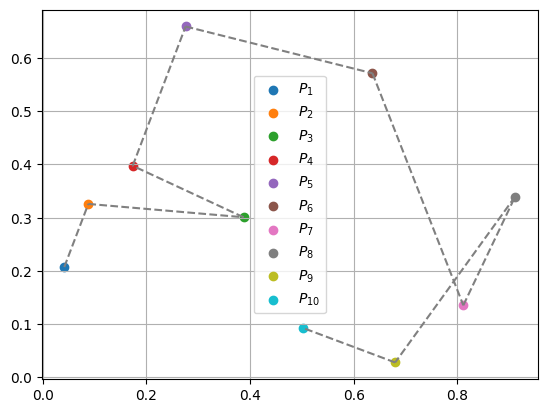

In [10]:
# --- Solution plot ---
for i in range(N-1):
    plt.plot(c[P[i:i+2],0], c[P[i:i+2],1], color='gray', linestyle='dashed')

for i in range(N):
    plt.scatter(c[P[i],0], c[P[i],1], label=f'$P_{{{i+1}}}$')

plt.legend()
plt.grid()
plt.show()